# Import des librairies nécessaires

In [180]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import classification_report
from sklearn.cluster import AgglomerativeClustering
from utils import plot_dendrogram

# Pré-traitement des données

## Ouverture du jeu de données et informations générales

In [181]:
data = pd.read_csv("fetal_health.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [182]:
data_with_fetal_health = data.copy()

In [183]:
data_descriptions = {
    'baseline_value': 'Fréquence cardiaque fœtale de base (FCF)',
    'accelerations': 'Nombre d\'accélérations par seconde',
    'fetal_movement': 'Nombre de mouvements fœtaux par seconde',
    'uterine_contractions': 'Nombre de contractions utérines par seconde',
    'light_decelerations': 'Nombre de décélérations légères par seconde',
    'severe_decelerations': 'Nombre de décélérations sévères par seconde',
    'prolongued_decelerations': 'Nombre de décélérations prolongées par seconde',
    'abnormal_short_term_variability': 'Pourcentage de temps avec une variabilité à court terme anormale',
    'mean_value_of_short_term_variability': 'Valeur moyenne de la variabilité à court terme',
    'percentage_of_time_with_abnormal_long_term_variability': 'Pourcentage de temps avec une variabilité à long terme anormale',
    'mean_value_of_long_term_variability': 'Valeur moyenne de la variabilité à long terme',
    'histogram_width': 'Largeur de l\'histogramme utilisant toutes les valeurs d\'un enregistrement',
    'histogram_min': 'Valeur minimale de l\'histogramme',
    'histogram_max': 'Valeur maximale de l\'histogramme',
    'histogram_number_of_peaks': 'Nombre de pics dans l\'histogramme de l\'examen',
    'histogram_number_of_zeroes': 'Nombre de zéros dans l\'histogramme de l\'examen',
    'histogram_mode': 'Mode de l\'histogramme',
    'histogram_mean': 'Moyenne de l\'histogramme',
    'histogram_median': 'Médiane de l\'histogramme',
    'histogram_variance': 'Variance de l\'histogramme',
    'histogram_tendency': 'Tendance de l\'histogramme',
    'fetal_health': 'Santé fœtale: 1 - Normal 2 - Suspect 3 - Pathologique'
}

df_descriptions = pd.DataFrame.from_dict(data_descriptions, orient='index', columns=['Description'])
print(df_descriptions)


                                                                                          Description
baseline_value                                               Fréquence cardiaque fœtale de base (FCF)
accelerations                                                      Nombre d'accélérations par seconde
fetal_movement                                                Nombre de mouvements fœtaux par seconde
uterine_contractions                                      Nombre de contractions utérines par seconde
light_decelerations                                       Nombre de décélérations légères par seconde
severe_decelerations                                      Nombre de décélérations sévères par seconde
prolongued_decelerations                               Nombre de décélérations prolongées par seconde
abnormal_short_term_variability                     Pourcentage de temps avec une variabilité à co...
mean_value_of_short_term_variability                   Valeur moyenne de la variab

Ici l'on peut voir que pandas interpréte correctement les différents types de données, sauf pour *fetal_health* qui dans notre cas devrait être catégorielle et ordonnée (3 est plus grave que 2 qui est plus grave que 1)

## Conversion de la variable *fetal_health* en variable qualitative ordinale

In [184]:
data.fetal_health = pd.Categorical(data.fetal_health, categories=[1.0, 2.0, 3.0], ordered=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype   
---  ------                                                  --------------  -----   
 0   baseline value                                          2126 non-null   float64 
 1   accelerations                                           2126 non-null   float64 
 2   fetal_movement                                          2126 non-null   float64 
 3   uterine_contractions                                    2126 non-null   float64 
 4   light_decelerations                                     2126 non-null   float64 
 5   severe_decelerations                                    2126 non-null   float64 
 6   prolongued_decelerations                                2126 non-null   float64 
 7   abnormal_short_term_variability                         2126 non-null   float64 
 8   mean_value_of_short_term_var

## Affichage du nombre de valeurs différentes et du nombre de valeurs manquantes

In [185]:
print(f"Nombre de valeurs différentes par variables :\n{data.nunique()}")
print()
print(f"Nombre de valeurs manquantes par variables :\n{data.isna().sum()}")

Nombre de valeurs différentes par variables :
baseline value                                             48
accelerations                                              20
fetal_movement                                            102
uterine_contractions                                       16
light_decelerations                                        16
severe_decelerations                                        2
prolongued_decelerations                                    6
abnormal_short_term_variability                            75
mean_value_of_short_term_variability                       57
percentage_of_time_with_abnormal_long_term_variability     87
mean_value_of_long_term_variability                       249
histogram_width                                           154
histogram_min                                             109
histogram_max                                              86
histogram_number_of_peaks                                  18
histogram_number_of_zero

Ici on voit qu'aucune variable n'est constante (aucune variable n'a qu'une seule et unique valeur), et l'on remarque aussi que le jeu de données ne contient aucune valeurs vides, ce qui nous arrange pour la suite.

# Exploration et visualisation des données

## Effectifs de chaque classe

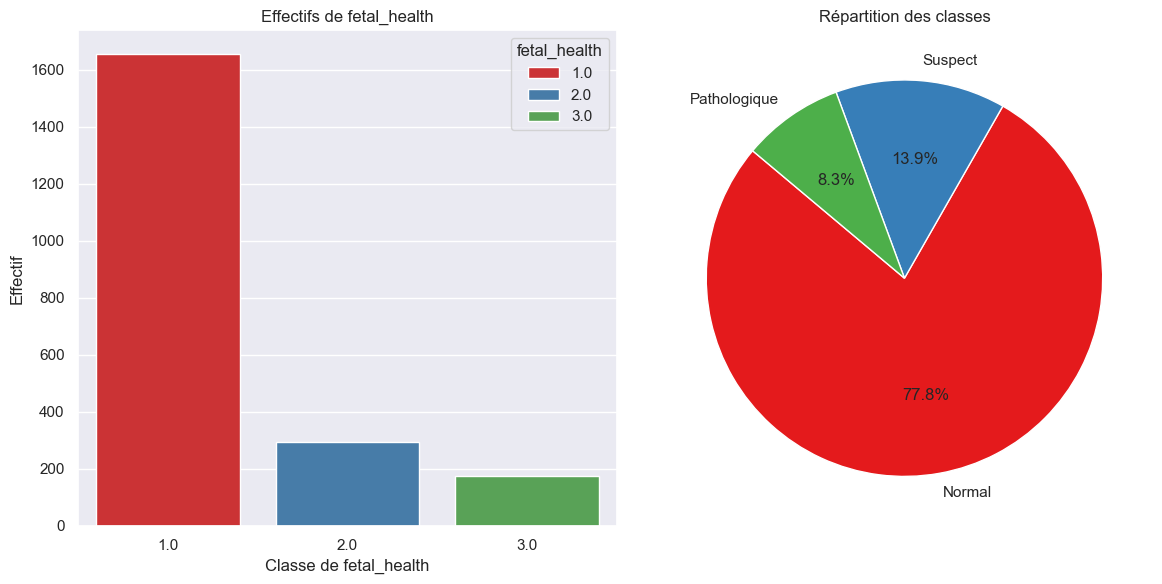

In [186]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x='fetal_health', hue="fetal_health", palette="Set1", data=data, ax=axes[0])
axes[0].set_title('Effectifs de fetal_health')
axes[0].set_xlabel('Classe de fetal_health')
axes[0].set_ylabel('Effectif')

plt.pie(data["fetal_health"].value_counts(normalize=True), labels=["Normal", "Suspect", "Pathologique"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set1'))
axes[1].set_title('Répartition des classes')
axes[1].set_ylabel('')

# plt.save_fig('repartition_classes.png')
plt.tight_layout()
plt.show()

On remarque un certain déséquilibre dans les classes de *fetal_health*, ce qui est normal.

## Statistiques descriptives de base

In [187]:
data.describe()

baseline value  accelerations  fetal_movement  uterine_contractions  \
count     2126.000000    2126.000000     2126.000000           2126.000000   
mean       133.303857       0.003178        0.009481              0.004366   
std          9.840844       0.003866        0.046666              0.002946   
min        106.000000       0.000000        0.000000              0.000000   
25%        126.000000       0.000000        0.000000              0.002000   
50%        133.000000       0.002000        0.000000              0.004000   
75%        140.000000       0.006000        0.003000              0.007000   
max        160.000000       0.019000        0.481000              0.015000   

       light_decelerations  severe_decelerations  prolongued_decelerations  \
count          2126.000000           2126.000000               2126.000000   
mean              0.001889              0.000003                  0.000159   
std               0.002960              0.000057                  0.000590   
min               0.000000              0.000000                  0.000000   
25%               0.000000              0.000000                  0.000000   
50%               0.000000              0.000000                  0.000000   
75%               0.003000              0.000000                  0.000000   
max               0.015000              0.001000                  0.005000   

       abnormal_short_term_variability  mean_value_of_short_term_variability  \
count                      2126.000000                           2126.000000   
mean                         46.990122                              1.332785   
std                          17.192814                              0.883241   
min                          12.000000                              0.200000   
25%                          32.000000                              0.700000   
50%                          49.000000                              1.200000   
75%                          61.000000                              1.700000   
max                          87.000000                              7.000000   

       percentage_of_time_with_abnormal_long_term_variability  ...  \
count                                         2126.00000       ...   
mean                                             9.84666       ...   
std                                             18.39688       ...   
min                                              0.00000       ...   
25%                                              0.00000       ...   
50%                                              0.00000       ...   
75%                                             11.00000       ...   
max                                             91.00000       ...   

       histogram_width  histogram_min  histogram_max  \
count      2126.000000    2126.000000    2126.000000   
mean         70.445908      93.579492     164.025400   
std          38.955693      29.560212      17.944183   
min           3.000000      50.000000     122.000000   
25%          37.000000      67.000000     152.000000   
50%          67.500000      93.000000     162.000000   
75%         100.000000     120.000000     174.000000   
max         180.000000     159.000000     238.000000   

       histogram_number_of_peaks  histogram_number_of_zeroes  histogram_mode  \
count                2126.000000                 2126.000000     2126.000000   
mean                    4.068203                    0.323612      137.452023   
std                     2.949386                    0.706059       16.381289   
min                     0.000000                    0.000000       60.000000   
25%                     2.000000                    0.000000      129.000000   
50%                     3.000000                    0.000000      139.000000   
75%                     6.000000                    0.000000      148.000000   
max                    18.000000                   10.000000      187.000000   

       histogram_mean  

## Histogrammes de chaque variable avec decoupage en fonction de la classe

In [188]:
sns.set_context("notebook")


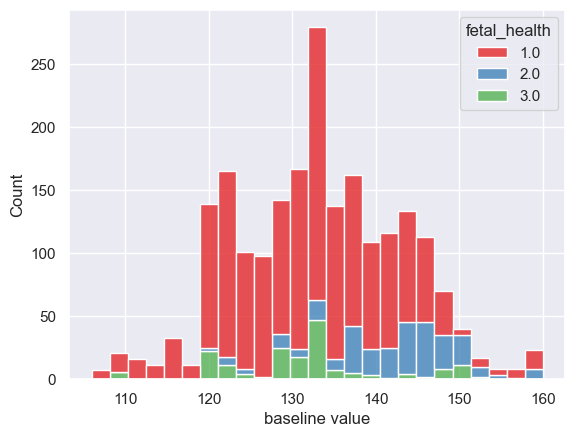

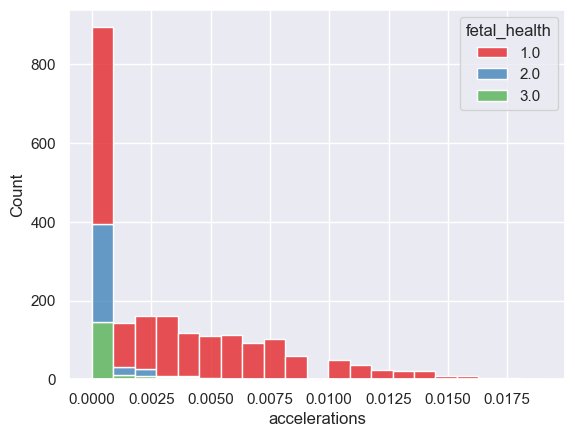

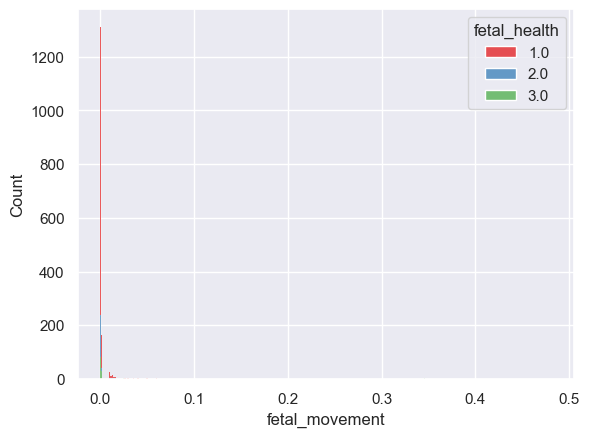

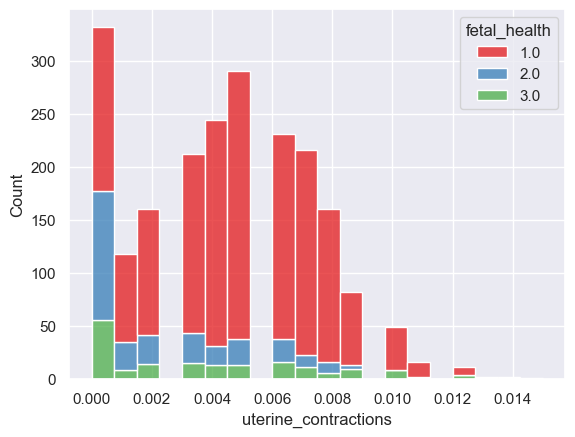

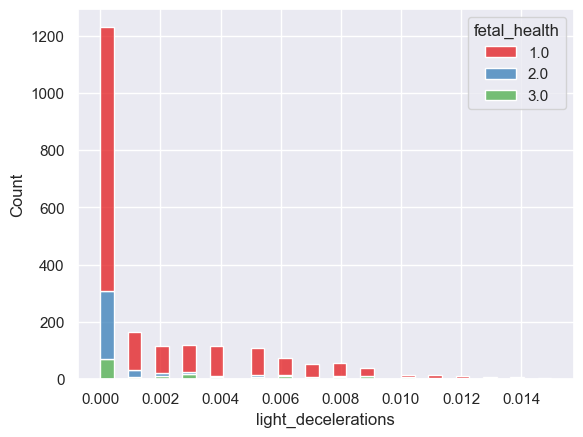

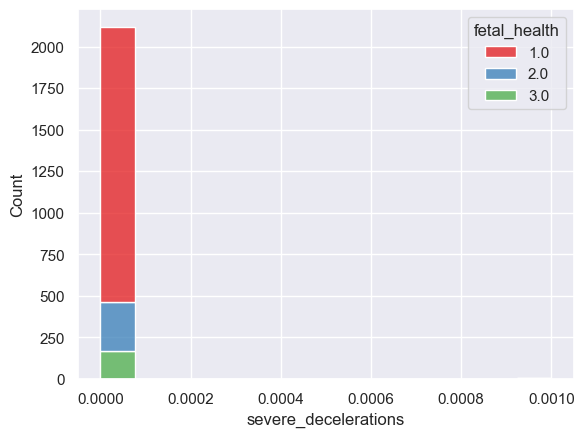

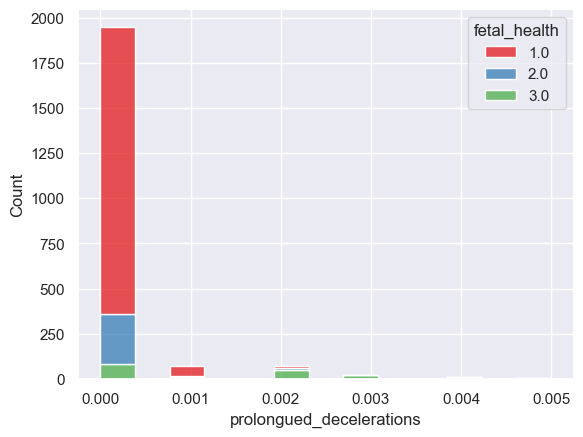

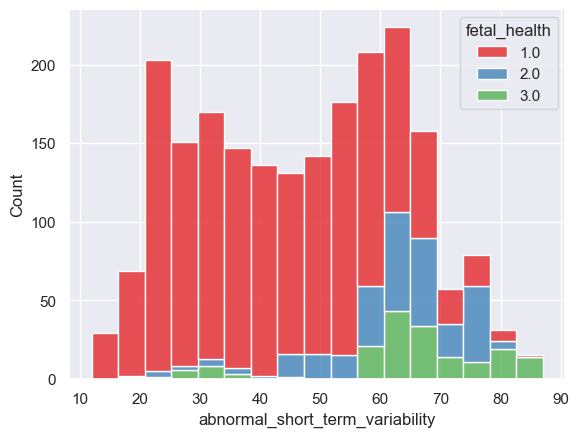

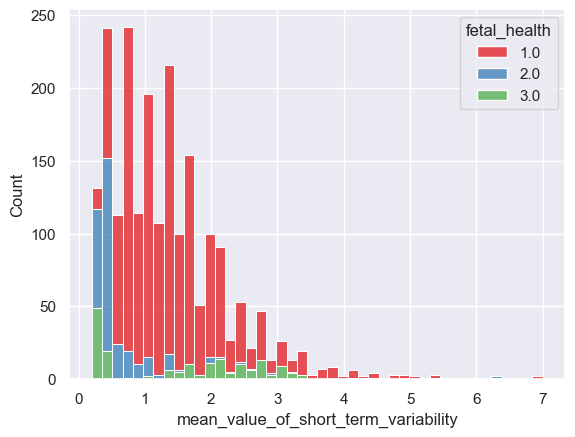

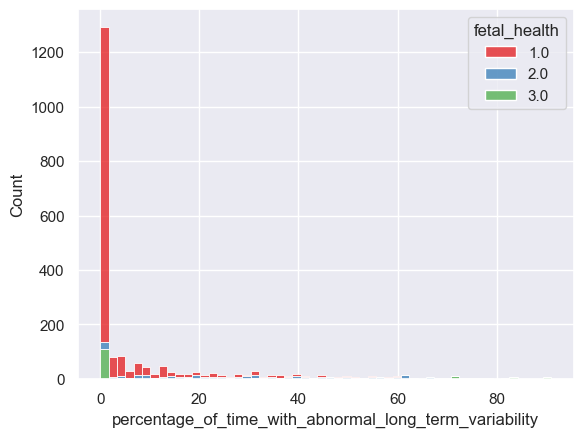

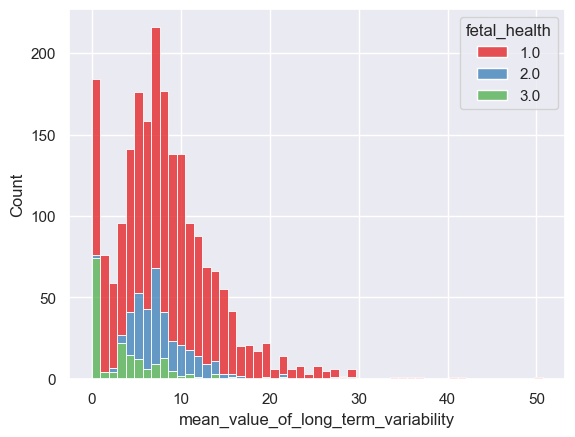

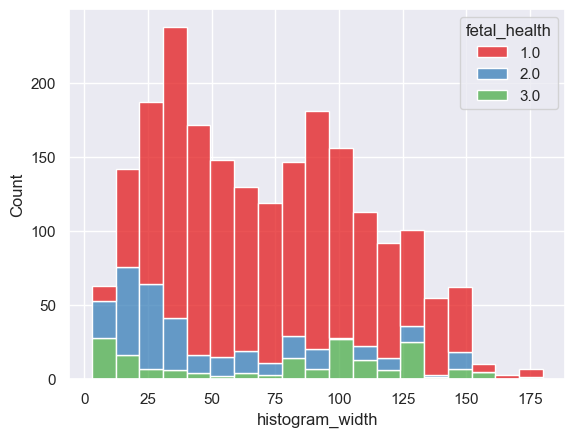

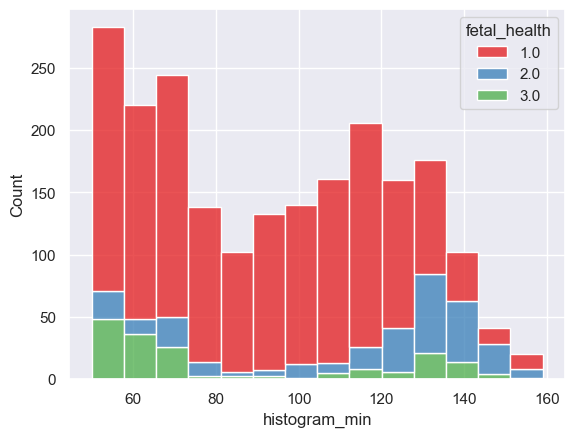

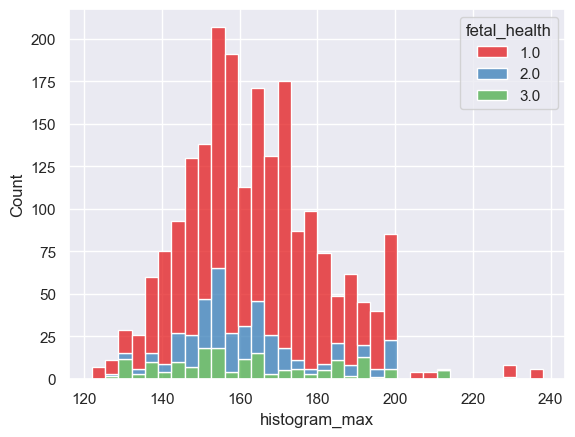

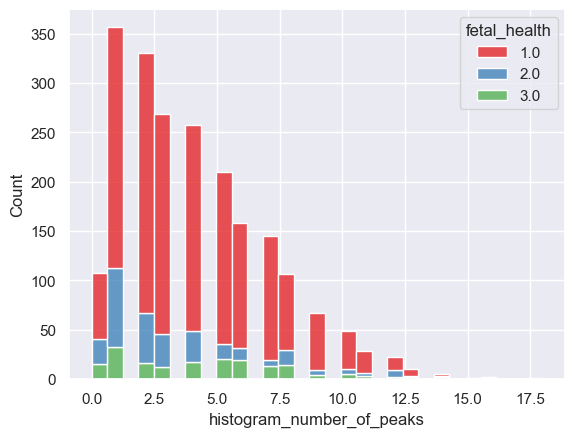

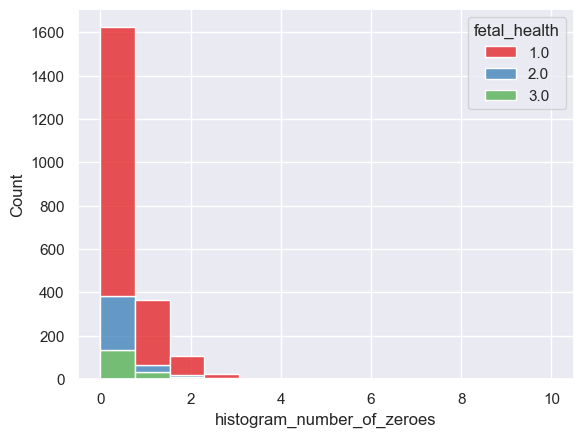

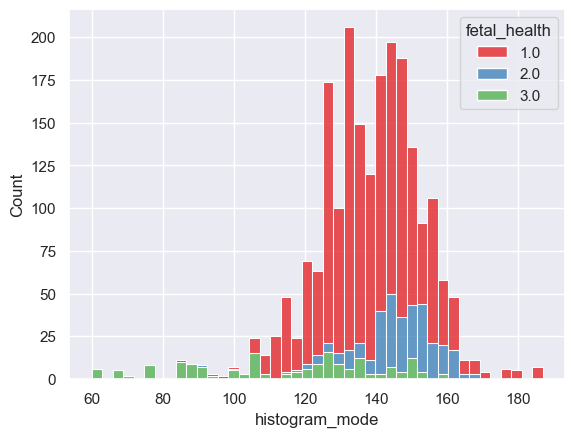

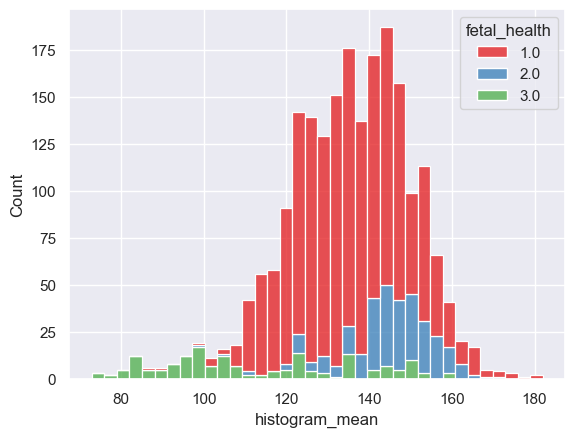

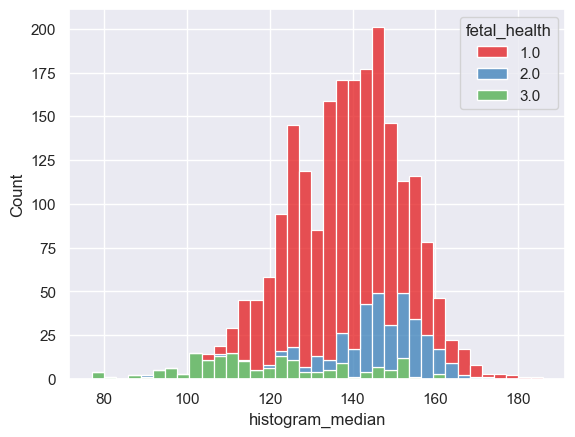

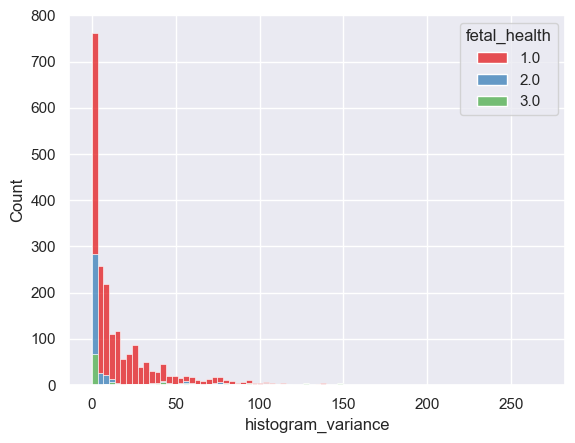

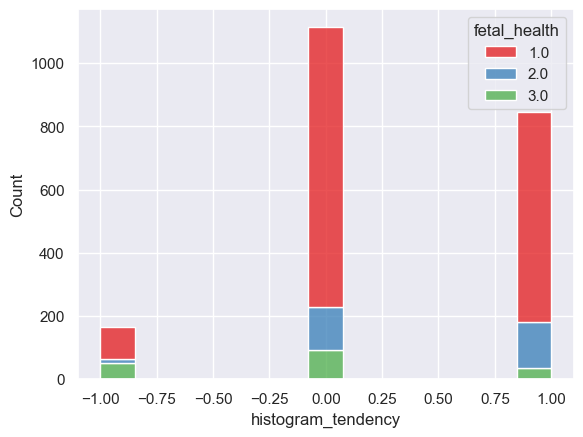

In [189]:
for column in data.columns:
    if column != "fetal_health":
        sns.histplot(x=column, hue="fetal_health", multiple="stack", palette="Set1", data=data)
        plt.show()

## Boxplot pour chaque variable

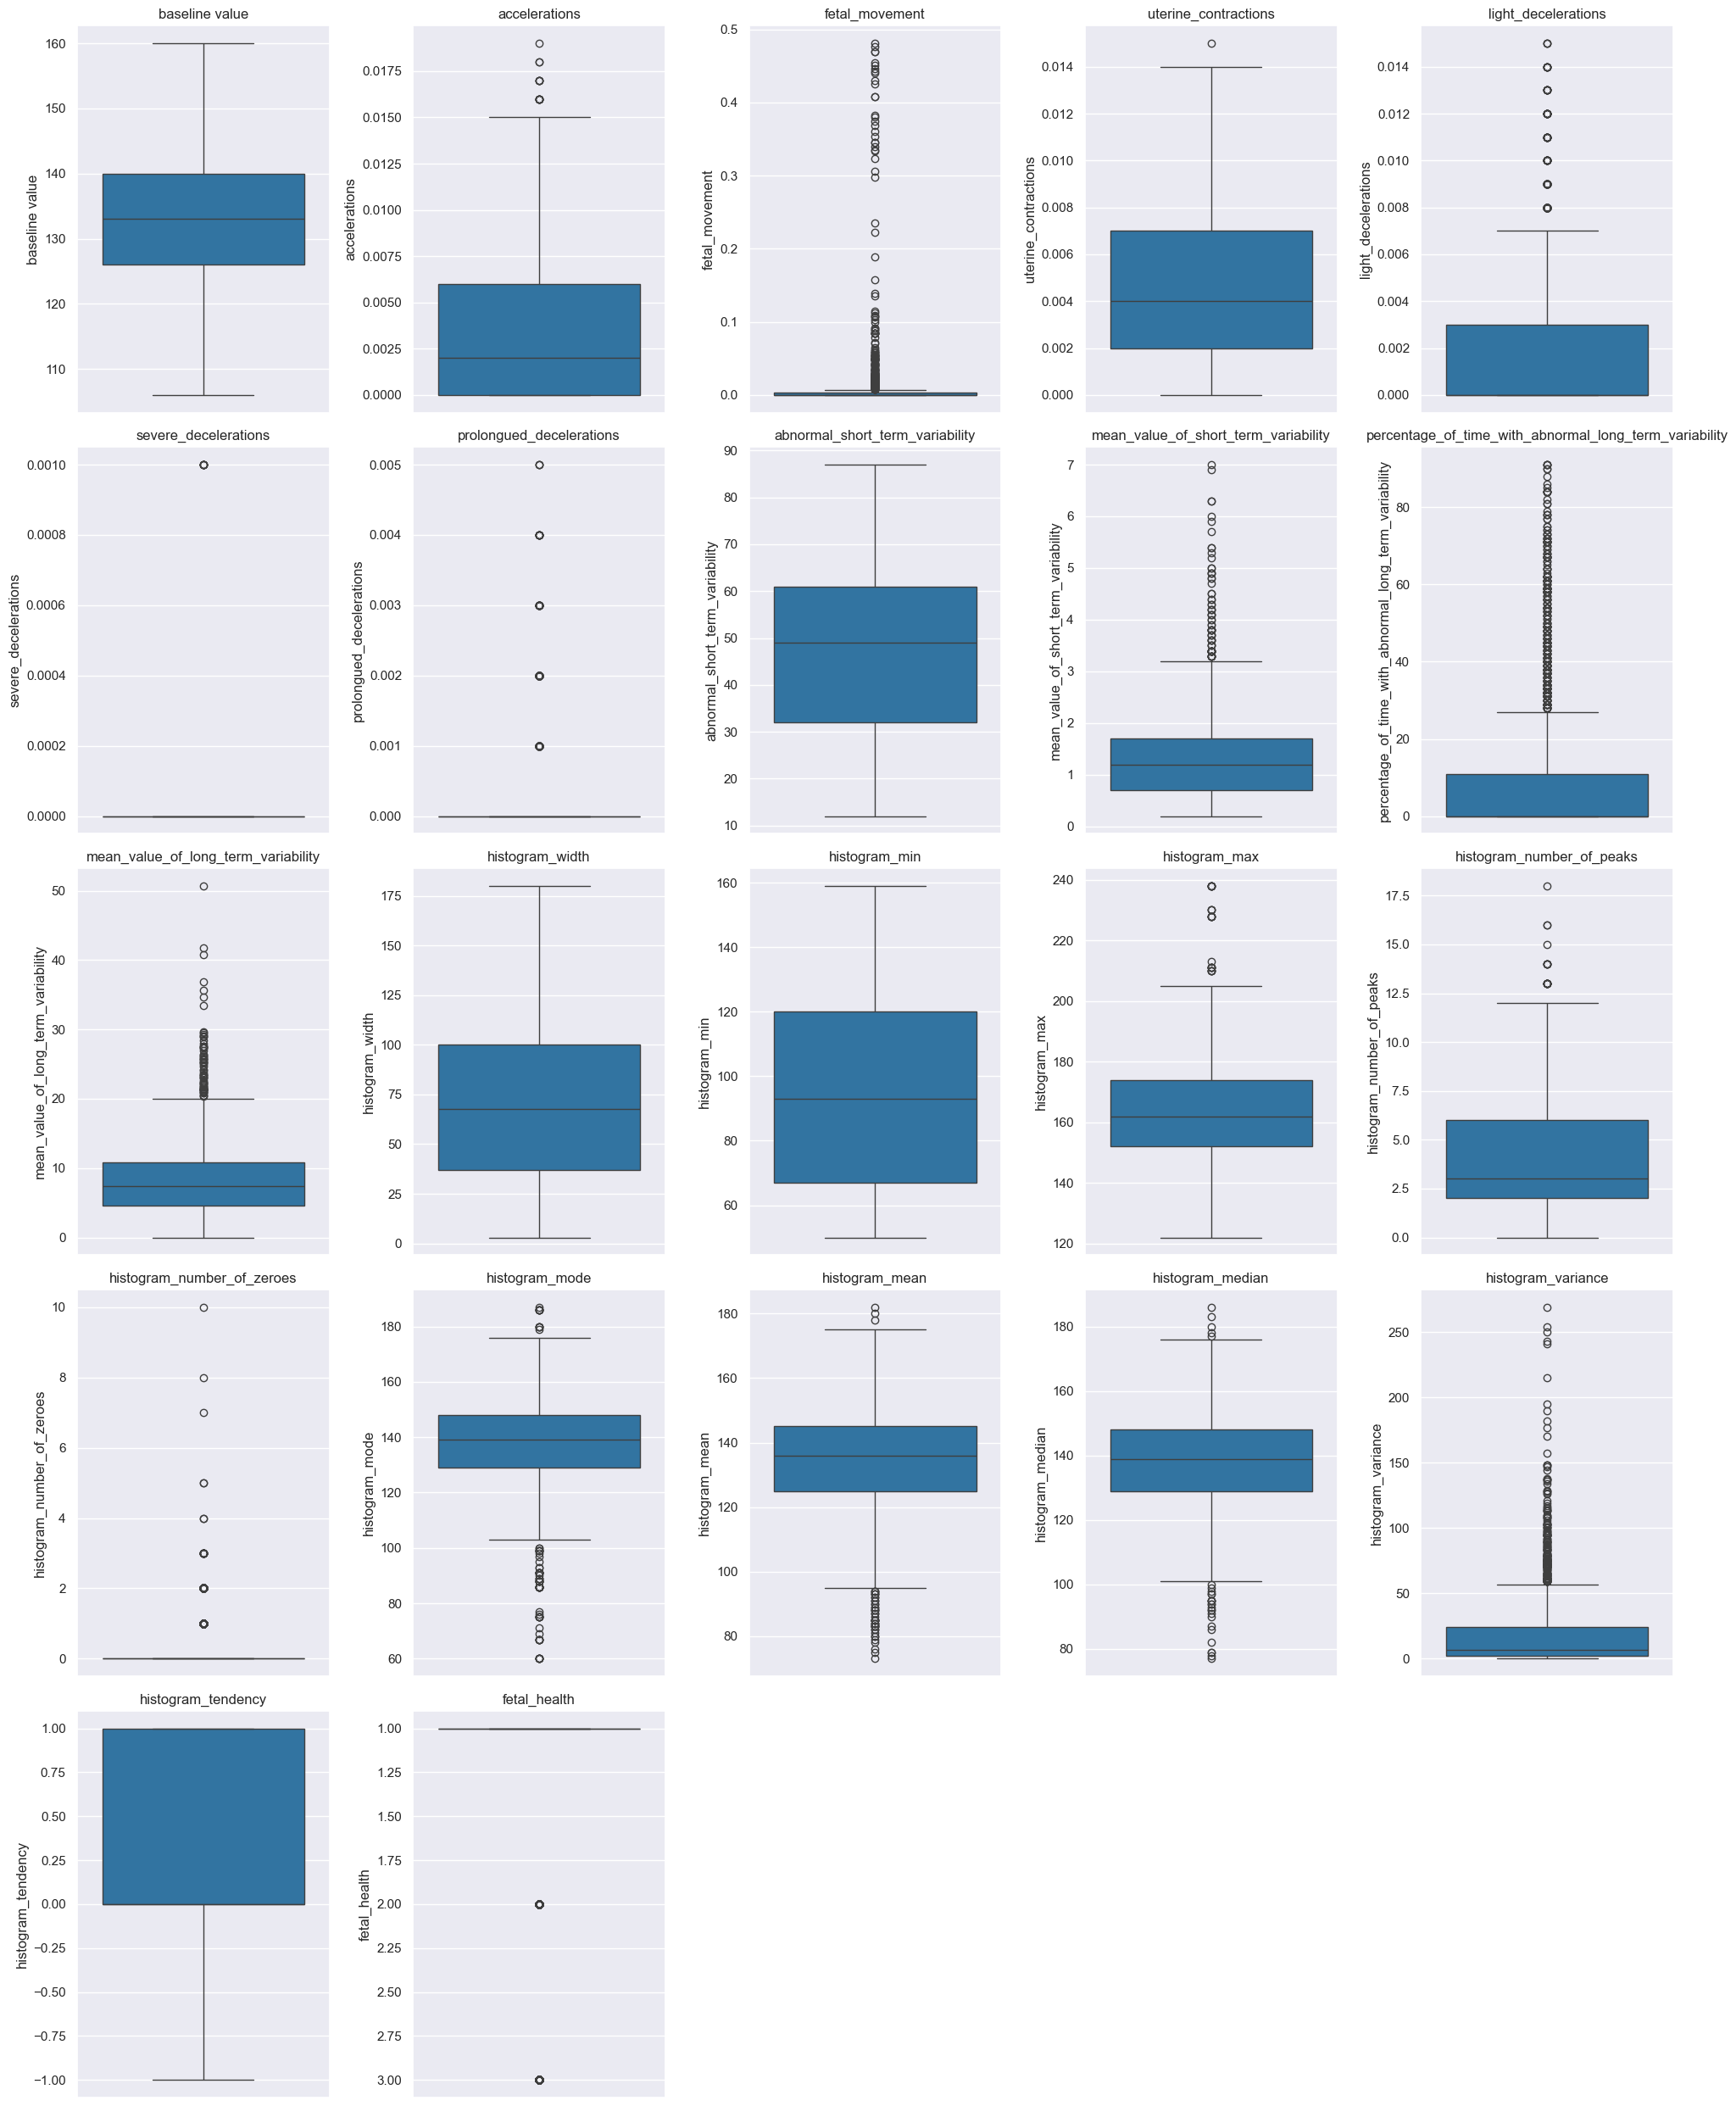

In [190]:
# Define the number of columns per row
columns_per_row = 5

# Calculate the number of rows
num_rows = (len(data.columns) + columns_per_row - 1) // columns_per_row

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=columns_per_row, figsize=(20, 5*num_rows))

# Flatten axes if only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

# Plot boxplots
for i, column in enumerate(data.columns):
    row = i // columns_per_row
    col = i % columns_per_row
    sns.boxplot(y=column, data=data, ax=axes[row, col])
    axes[row, col].set_title(column)

# Hide empty subplots
for i in range(len(data.columns), num_rows * columns_per_row):
    row = i // columns_per_row
    col = i % columns_per_row
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

## Boxplot pour chaque variable, avec distinction de classe

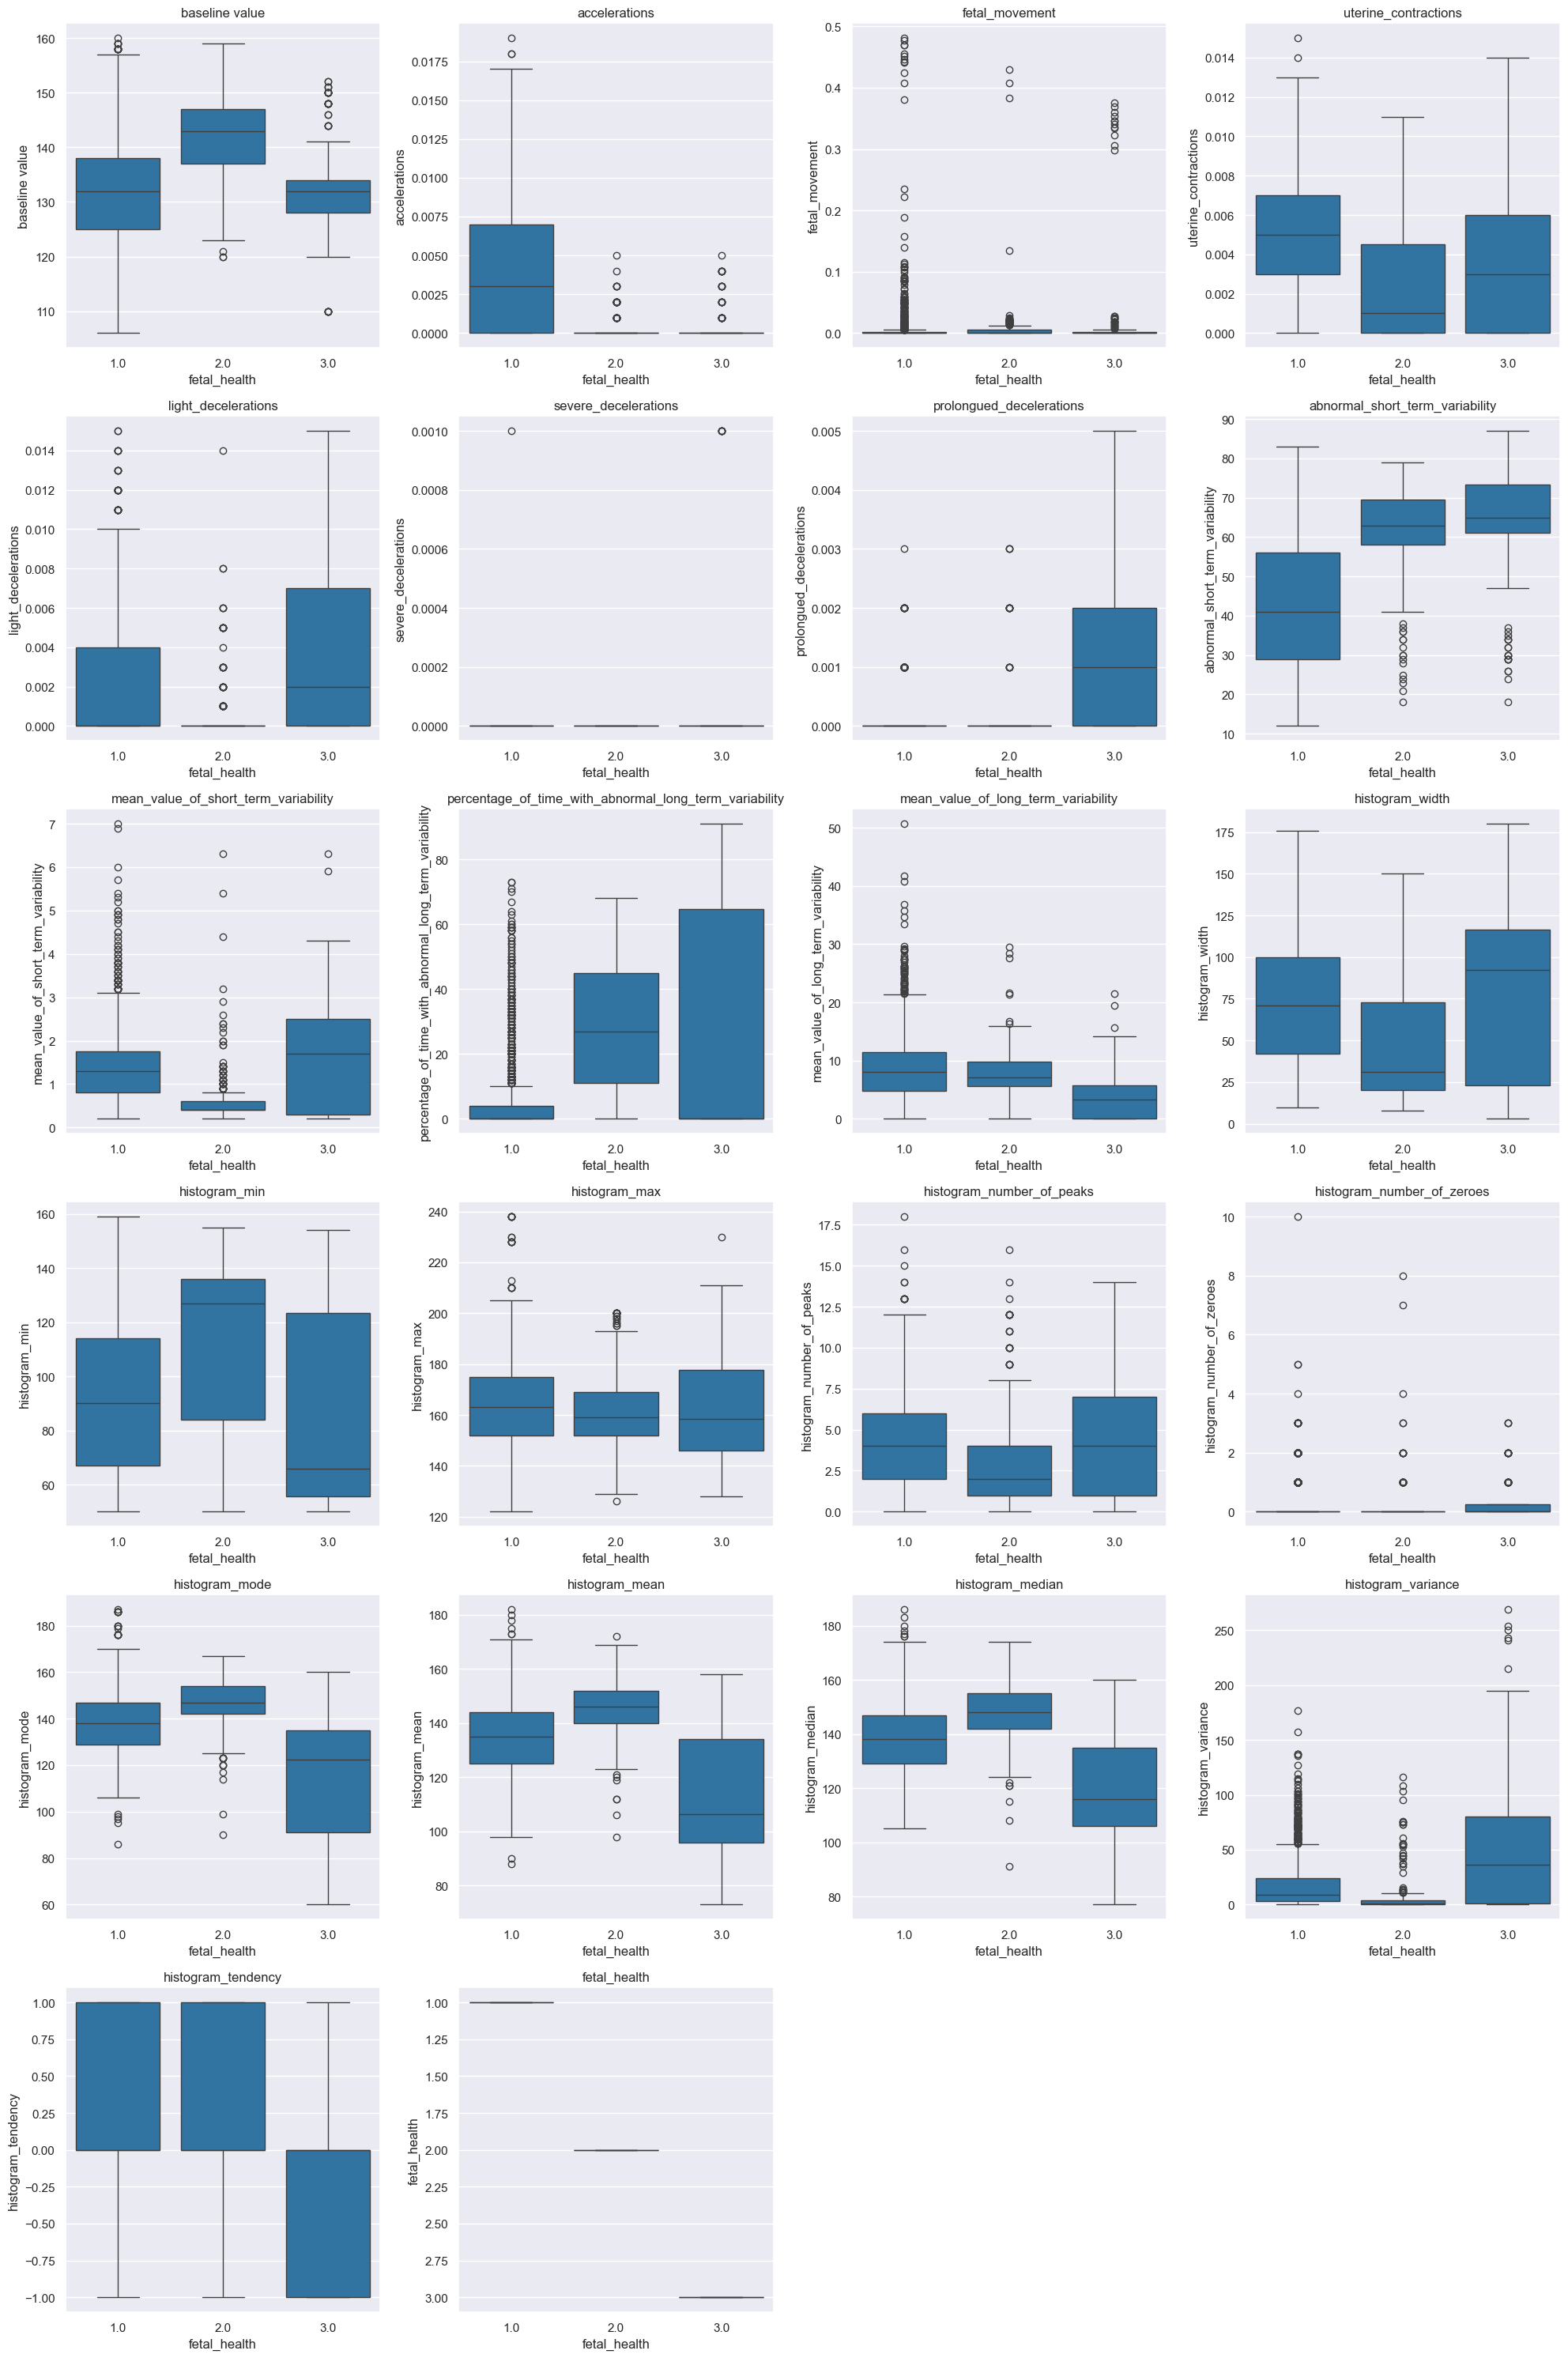

In [191]:
# Define the number of columns per row
columns_per_row = 4

# Calculate the number of rows
num_rows = (len(data.columns) + columns_per_row - 1) // columns_per_row

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=columns_per_row, figsize=(20, 5*num_rows))

# Flatten axes if only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

# Plot boxplots
for i, column in enumerate(data.columns):
    row = i // columns_per_row
    col = i % columns_per_row
    sns.boxplot(y=column, data=data, ax=axes[row, col], x=data.fetal_health)
    axes[row, col].set_title(column)

# Hide empty subplots
for i in range(len(data.columns), num_rows * columns_per_row):
    row = i // columns_per_row
    col = i % columns_per_row
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

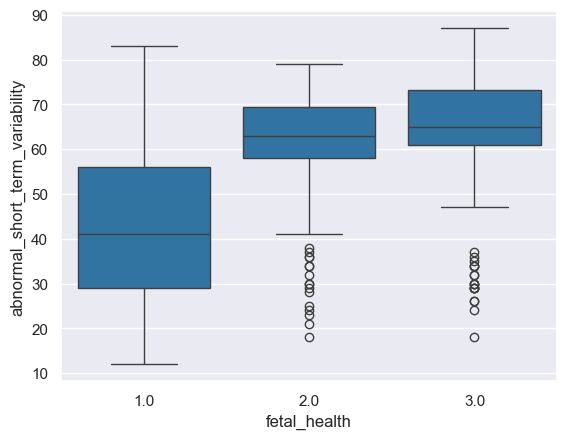

In [192]:
sns.boxplot(data=data, x='fetal_health', y='abnormal_short_term_variability')
plt.savefig("ex_boxplot.png")

# Calcul de corrélations

## Matrice de corrélation

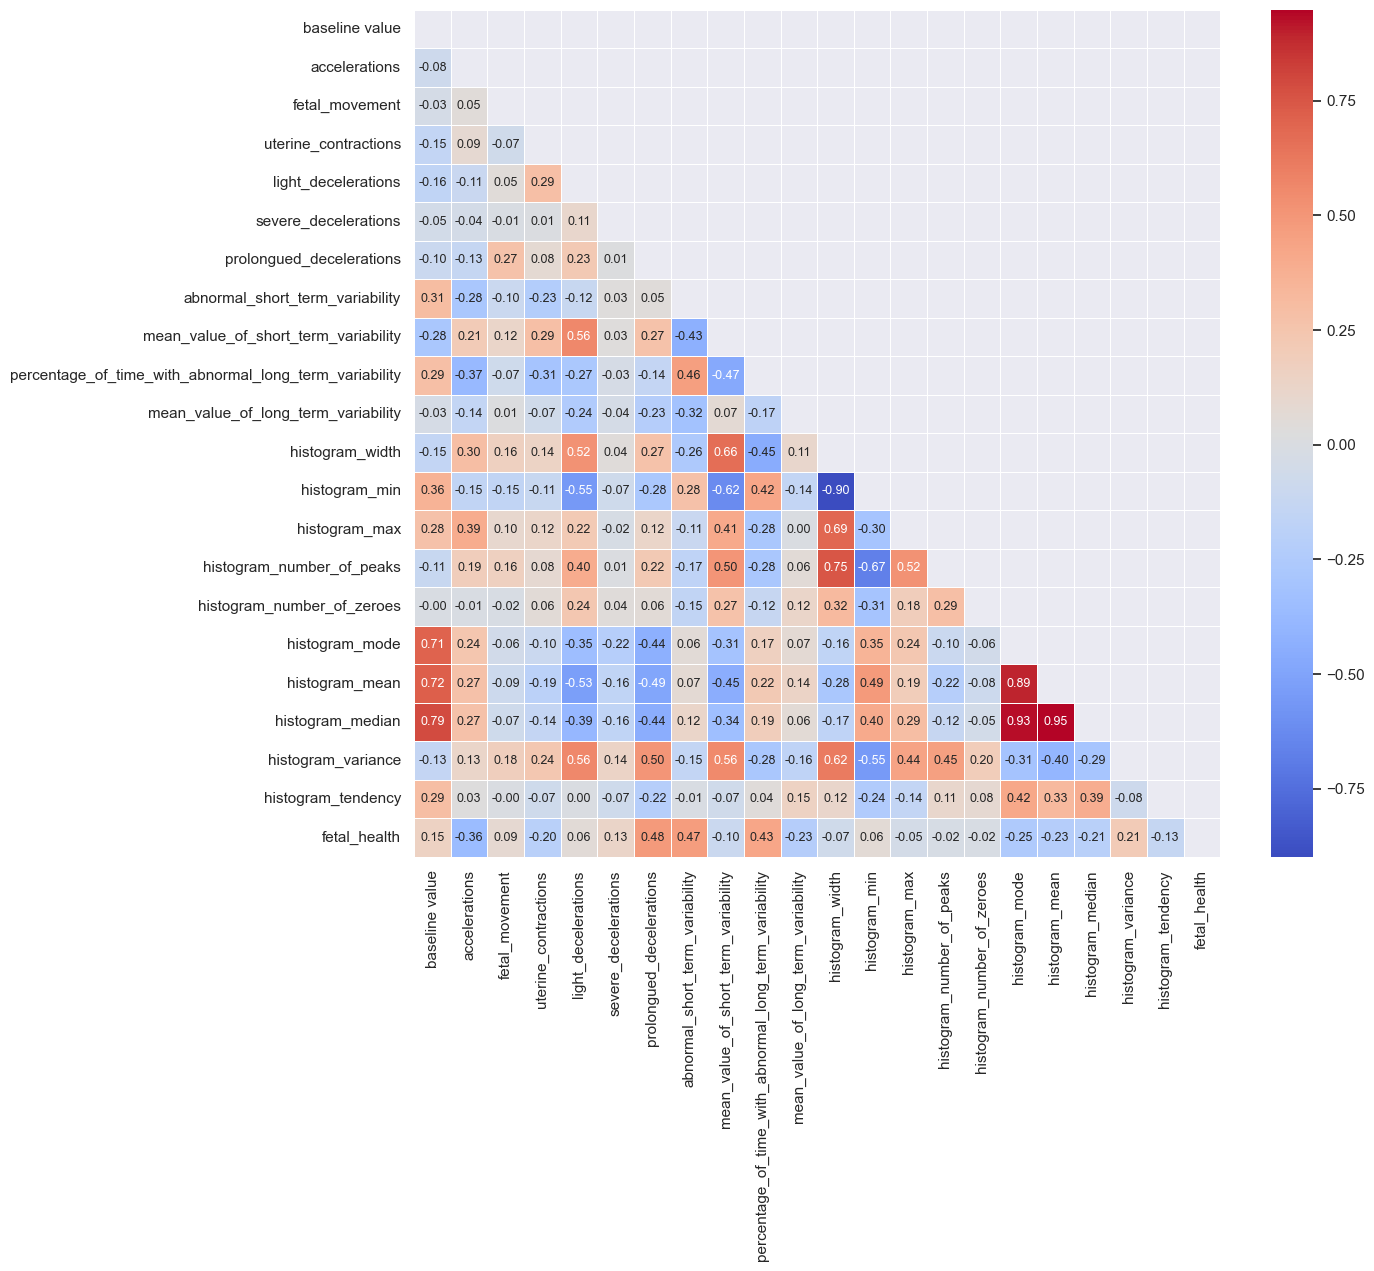

In [193]:
corr = data.corr('pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(13, 11))
plt.grid(False)
sns.heatmap(corr, mask=mask, cmap='coolwarm', linewidths=0.5, annot=True, annot_kws={"fontsize":9}, fmt='.2f')
plt.show()

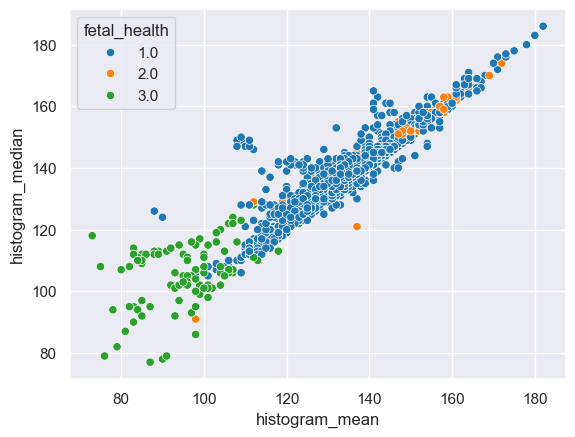

In [194]:
sns.scatterplot(data=data, x="histogram_mean", y="histogram_median", hue="fetal_health")
plt.savefig("scatter_mean_median.png")
plt.show()

## Correlation avec la sortie

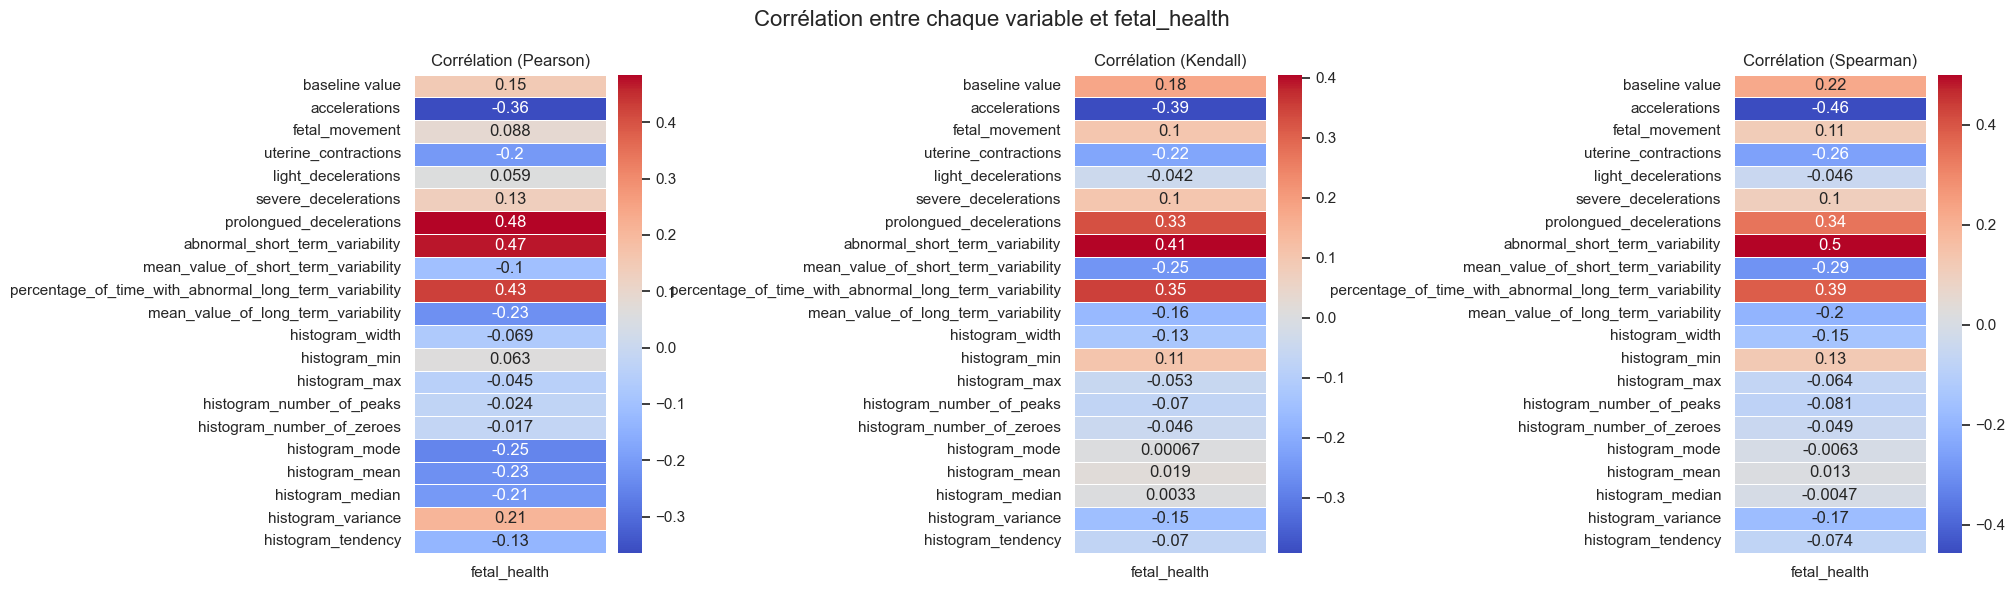

In [195]:
correlation_methods = ['pearson', 'kendall', 'spearman']
correlation_data = {}

for method in correlation_methods:
    correlation_data[method] = data.corr(method=method)['fetal_health']

# Création d'une figure avec 3 sous-graphes
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Tracé des heatmaps pour chaque méthode de corrélation
for i, method in enumerate(correlation_methods):
    correlation_df = pd.DataFrame(correlation_data[method])
    correlation_df = correlation_df.drop('fetal_health')
    
    sns.heatmap(correlation_df, cmap='coolwarm', linewidths=0.5, annot=True, ax=axes[i])
    axes[i].set_title('Corrélation ({})'.format(method.capitalize()))

plt.suptitle('Corrélation entre chaque variable et fetal_health', fontsize=16)
plt.tight_layout()

On remarque que les variables "accelerations","prolongued_decelerations", "abnormal_short_term_variability", "percentage_of_time_with_abnormal_long_term_variability" et "mean_value_of_long_term_variability" sont celles qui sont le plus corrélé  à la santé du foetus

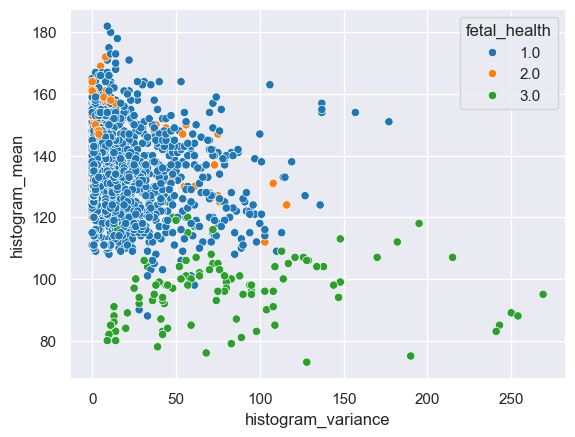

In [196]:
sns.scatterplot(data,x="histogram_variance",y="histogram_mean", hue="fetal_health")
plt.show()

## Quelques scatterplot

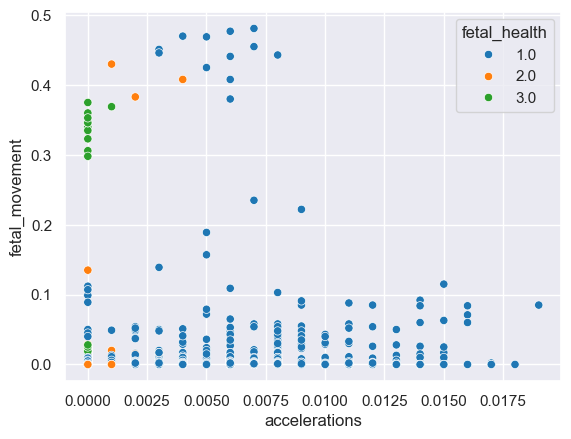

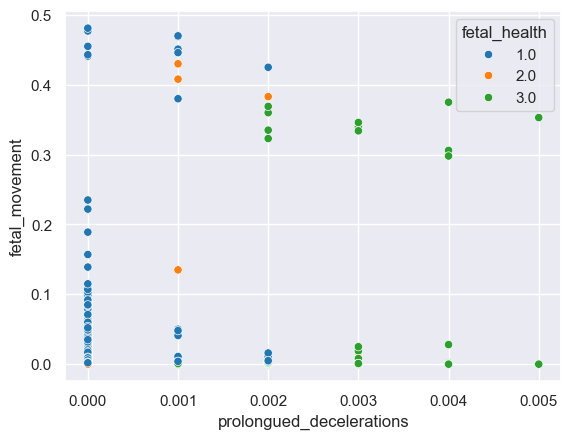

In [197]:
sns.scatterplot(data =data,x="accelerations",y="fetal_movement", hue="fetal_health")
plt.show()
sns.scatterplot(data =data,x="prolongued_decelerations",y="fetal_movement", hue="fetal_health")
plt.show()

# Analyse en Composantes principales (ACP)

## ACP non-normalisée

### Pourcentages d'inertie expliquée

Part d'inertie expliquée par chaque composante:
[0.589, 0.161, 0.097, 0.07, 0.037, 0.028, 0.006, 0.005, 0.004, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


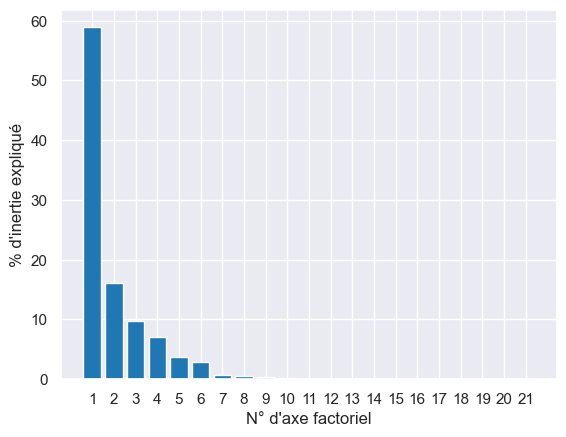

In [223]:
data_without_class = data.drop('fetal_health', axis=1)
cls = PCA(n_components=21)
pcs = cls.fit_transform(data_without_class)
print(f"Part d'inertie expliquée par chaque composante:\n{[round(value, 3) for value in cls.explained_variance_ratio_]}")

plt.bar([f"{i}" for i in range(1, 22)], cls.explained_variance_ratio_*100)
plt.xlabel("N° d'axe factoriel")
plt.ylabel("% d'inertie expliqué")
#plt.savefig("%inertie_axe.png")
plt.show()

On remarque que dès le deuxième axe factoriel, le pourcentage d'inertie expliquée est faible voir très faible.
Les axes factoriels 1 et 2 expliquent 74% de l'inertie. 

### Représentation dans le premier plan factoriel

In [224]:
fig = px.scatter(x=pcs.T[0], y=pcs.T[1], color=data['fetal_health'], 
                 labels={'x': 'PC1', 'y': 'PC2'}, width=650)
fig.show()

In [225]:
# Pour enregister au format png
# sns.scatterplot(x=pcs.T[0], y=pcs.T[1], hue=data['fetal_health'], palette="Set1")
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.savefig("premier_plan.png")

On remarque, dans une certaine mesure que les observations de même classe sont rassemblées. Mais les clusters sont souvent confondus donc, en l'état (avec seulement une représentation dans le plan), on aura du mal à prédire la classe avec un algorithme de clustering.

## ACP normalisée

### Pourcentages d'inertie expliquée

Part d'inertie expliquée par chaque composante:
[0.288, 0.167, 0.087, 0.071, 0.058, 0.049, 0.047, 0.044, 0.036, 0.03, 0.027, 0.024, 0.019, 0.016, 0.013, 0.009, 0.006, 0.006, 0.002, 0.001, 0.0]


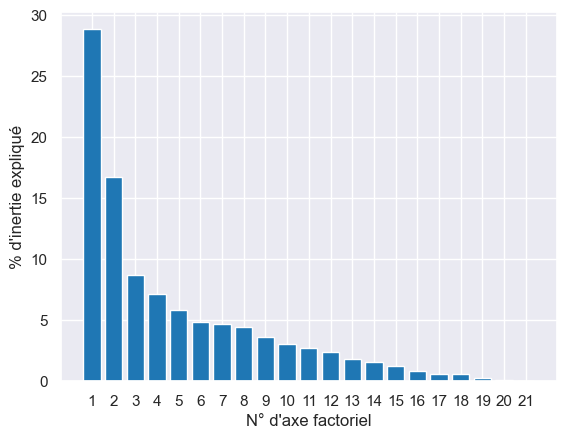

In [226]:
data_without_class_copy = data_without_class.copy()
scaler = StandardScaler()
scaled_data_without_class = scaler.fit_transform(data_without_class_copy)
cls_scaled = PCA(n_components=21)
pcs_scaled = cls_scaled.fit_transform(scaled_data_without_class)
print(f"Part d'inertie expliquée par chaque composante:\n{[round(value, 3) for value in cls_scaled.explained_variance_ratio_]}")

plt.bar([f"{i}" for i in range(1, 22)], cls_scaled.explained_variance_ratio_*100)
plt.xlabel("N° d'axe factoriel")
plt.ylabel("% d'inertie expliqué")
#plt.savefig("%inertie_axe.png")
plt.show()

### Représentation dans le premier plan factoriel

In [227]:
fig = px.scatter(x=pcs.T[0], y=pcs.T[1], color=data['fetal_health'], 
                 labels={'x': 'PC1', 'y': 'PC2'}, width=650)
fig.show()

In [203]:
# Pour enregister au format png
# sns.scatterplot(x=pcs.T[0], y=pcs.T[1], hue=data['fetal_health'], palette="Set1")
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.savefig("premier_plan_scaled.png")

## ACP normalisée et pondérée

### Pourcentages d'inertie expliquée

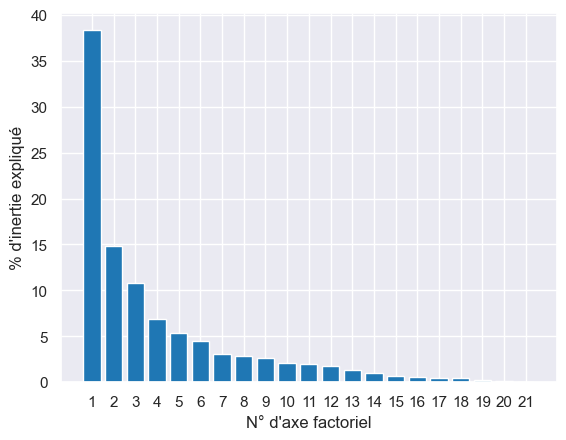

In [204]:
data_without_class_copy = data_without_class.copy()
effectifs = data['fetal_health'].value_counts()
scaler = StandardScaler()
# X = data_without_class_copy.to_numpy()
X = scaler.fit_transform(data_without_class_copy)
D = np.empty(len(data), dtype=float)

for i, row in enumerate(data.itertuples(index=False)):
    if row.fetal_health == 1.0:
        D[i] = 1/(3*effectifs[1.0])
    elif row.fetal_health == 2.0:
        D[i] = 1/(3*effectifs[2.0])
    elif row.fetal_health == 3.0:
        D[i] = 1/(3*effectifs[3.0])

D = np.diag(D)
V = np.matmul(X.T, np.matmul(D, X))
L, U = np.linalg.eig(V)

sorted_indices = np.argsort(L)[::-1]
L = L[sorted_indices]
U = U[:, sorted_indices]

plt.bar([f"{i}" for i in range(1, 22)], L/L.sum()*100)
plt.xlabel("N° d'axe factoriel")
plt.ylabel("% d'inertie expliqué")
#plt.savefig("%inertie_axe.png")
plt.show()

C = np.matmul(X, U)

### Représentation dans le premier plan factoriel

In [205]:
fig = px.scatter(x=C.T[0], y=C.T[1], color=data['fetal_health'], 
                 labels={'x': 'PC1', 'y': 'PC2'}, width=650)
fig.show()

In [206]:
# # Pour enregister au format png
# sns.scatterplot(x=C.T[0], y=C.T[1], hue=data['fetal_health'], palette="Set1")
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.savefig("premier_plan_pond.png")

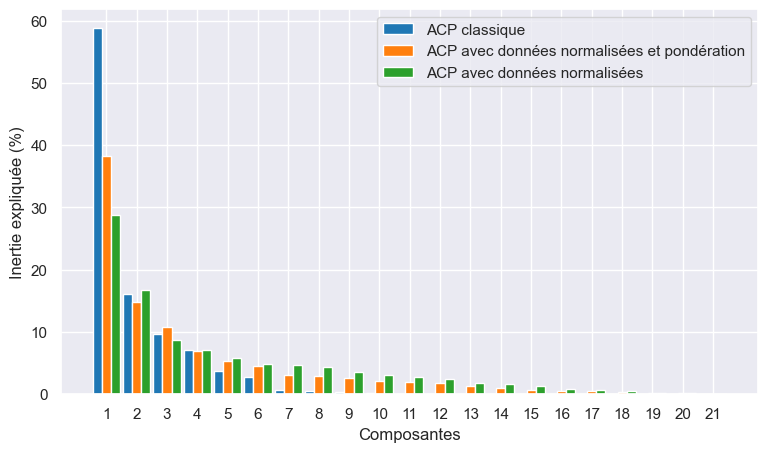

In [207]:
bar_width = 1.2
bar_space = 0.1
# Positions des barres sur l'axe x
x = 4*np.arange(len(L))
plt.figure(figsize=(9, 5))
# Tracer les barplots
plt.bar(x-bar_width, cls.explained_variance_ratio_*100, width=bar_width, label="ACP classique")
plt.bar(x, L/L.sum()*100, width=bar_width, label="ACP avec données normalisées et pondération")
plt.bar(x + bar_width, cls_scaled.explained_variance_ratio_*100, width=bar_width, label="ACP avec données normalisées")

# Étiquettes, titres, légende, etc.
plt.xlabel('Composantes')
plt.ylabel('Inertie expliquée (%)')
plt.xticks(x, [str(i) for i in range(1, len(x) + 1)])
plt.legend()
plt.savefig("inertie_comp.png")
# Afficher le graphique
plt.show()
# plt.plot(L/L.sum()*100, marker='o', label="ACP avec données normalisées et pondération")
# plt.plot(cls.explained_variance_ratio_*100, marker='x', label="ACP classique")
# plt.plot(cls_scaled.explained_variance_ratio_*100, marker='s', label="ACP avec données normalisées")
# x = [i for i in range(1, 22)]
# plt.xticks(range(len(x)), x)
# plt.legend()
# plt.show()

# Algorithme des K-Means sur les données 

## Nombre de clusters optimal

In [208]:
def kmeans_generator(dataset, n_clusters_list):
    for n_clusters in n_clusters_list:
        cls = KMeans(n_clusters=n_clusters, init="k-means++", n_init=200)
        km = cls.fit(dataset)
        inertia = km.inertia_
        yield n_clusters, inertia


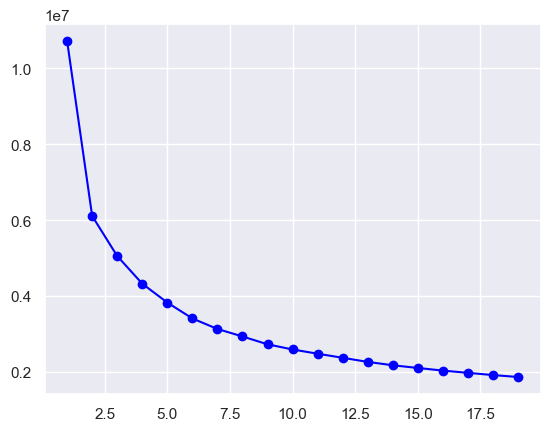

In [209]:
# data_without_class_copy = data_without_class.copy()
# scaler = StandardScaler()
# scaled_data_without_class = scaler.fit_transform(data_without_class_copy)
gen = kmeans_generator(data_without_class, [i for i in range(1,20)],)

elbow = pd.DataFrame(gen, columns=["n_clusters", "inertia"])
elbow = elbow.astype({"n_clusters": "int32"})
plt.plot(elbow["n_clusters"], elbow["inertia"], color="blue", marker="o")
plt.show()

Ici, un "coude" franc et net semble avoir du mal à se dessiner, pouvant indiquer des clusters assez peu marqués dans les données.

In [210]:
from kneed import KneeLocator

kneedle = KneeLocator(elbow["n_clusters"], elbow["inertia"], curve='convex', direction='decreasing')

knee_point = (kneedle.knee, elbow["inertia"][kneedle.knee])

print("Knee point:", knee_point)


Knee point: (5, 3407149.8623710778)


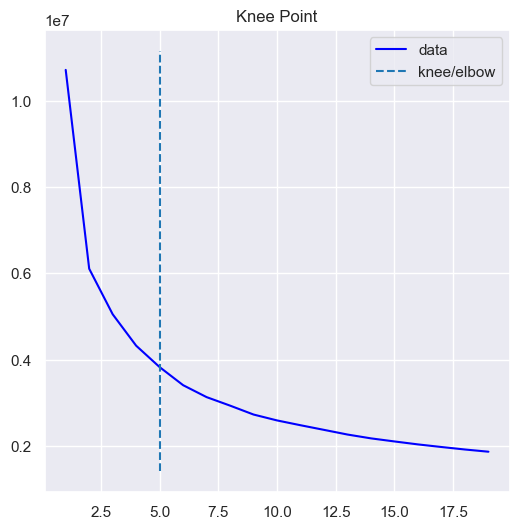

In [211]:
kneedle.plot_knee()

## Essai avec 3 clusters et comparaison avec la partition des données en 3 classes

Cette partie sera aussi l'occasion de voir si le fait de normaliser les données donne de meilleurs résultats ou non par rapport aux données brutes. En effet, le fait de normaliser ou non les données semble dépendre du problème et il n'y a pas l'air d'y avoir de consensus, donc à voir.

### Données normalisées

In [212]:
data_without_class_copy = data_without_class.copy()
scaler = StandardScaler()
scaled_data_without_class = scaler.fit_transform(data_without_class_copy)

cls = KMeans(n_clusters=3, init="k-means++",n_init=200)
cls.fit(scaled_data_without_class)
labels = pd.Series(cls.labels_, name="K-means")
labels = pd.Categorical(labels, categories=[0, 1, 2, 3])

symbol_categories = labels.astype(str)

fig = px.scatter(x=pcs.T[0], y=pcs.T[1], color=data['fetal_health'], symbol=labels,
                 labels={'x': 'PC1', 'y': 'PC2'}, width=650)
fig.show()



print(f"ARI : {adjusted_rand_score(labels, data['fetal_health'])}")

ARI : 0.19963943749214955


### Données non-normalisées

In [213]:
cls = KMeans(n_clusters=3, init="k-means++", n_init=200)
cls.fit(data_without_class)
labels = pd.Series(cls.labels_, name="K-means")
labels = pd.Categorical(labels, categories=[0, 1, 2, 3])

fig = px.scatter(x=pcs.T[0], y=pcs.T[1], color=data["fetal_health"], symbol=labels,
                 labels={'x': 'PC1', 'y': 'PC2'}, width=650)
fig.show()
print(f"ARI : {adjusted_rand_score(labels, data['fetal_health'])}")

ARI : 0.045778965097549994


L'indice de Rand ajusté (ARI) ne semble pas très bon dans les deux cas. Les K-Means ne semblent pas très adaptés pour représenter nos données selon la classe *fetal_health*

## Essai avec 5 clusters et comparaison avec la partition des données en 3 classes

In [214]:
data_without_class_copy = data_without_class.copy()
scaler = StandardScaler()
scaled_data_without_class = scaler.fit_transform(data_without_class_copy)

cls = KMeans(n_clusters=5, init="k-means++", n_init=200)
cls.fit(scaled_data_without_class)
labels = pd.Series(cls.labels_, name="K-means")
labels = pd.Categorical(labels, categories=[0, 1, 2, 3, 4])

fig = px.scatter(x=pcs.T[0], y=pcs.T[1], color=data['fetal_health'], symbol=labels,
                 labels={'x': 'PC1', 'y': 'PC2'}, width=650)
fig.show()
print(f"ARI : {adjusted_rand_score(labels, data['fetal_health'])}")

ARI : 0.09570412088337725


In [215]:
cls = KMeans(n_clusters=5, init="k-means++", n_init=200)
cls.fit(data_without_class)
labels = pd.Series(cls.labels_, name="K-means")
labels = pd.Categorical(labels, categories=[0, 1, 2, 3,4])

fig = px.scatter(x=pcs.T[0], y=pcs.T[1], color=data["fetal_health"], symbol=labels,
                 labels={'x': 'PC1', 'y': 'PC2'}, width=650)
fig.show()
print(f"ARI : {adjusted_rand_score(labels, data['fetal_health'])}")

ARI : 0.09336442318387028


On s'apercoit que le Rand Index n'est pas meilleur avec 5 clusters. Plutot que d'utiliser la méthode du coude, on va chercher à avoir le rand index maximal

## Recherche de la solution avec le meilleur rand index 

In [242]:
def kmeans(dataset, n_clusters_list):
    
    for scaled in ["Données normalisées","Données non-normalisées"] :
        
        if scaled=="Données normalisées":
            scaler = StandardScaler()
            kmeans_data = scaler.fit_transform(dataset) 
        else :
            kmeans_data = dataset
        for n_clusters in n_clusters_list:
            cls = KMeans(n_clusters=n_clusters, n_init=200)
            km = cls.fit(kmeans_data)
            labels = pd.Series(cls.labels_, name="K-means")
            labels = pd.Categorical(labels, categories=[i for i in range(n_clusters)])
            yield n_clusters, scaled, adjusted_rand_score(labels, data['fetal_health'])

gen = kmeans(data_without_class, [i+1 for i in range(11)])

df = pd.DataFrame(gen, columns=["n_clusters", "scaled","rand_index"])
df = df.astype({"n_clusters": "int32"})

sns.lineplot(df, x='n_clusters', y='rand_index', hue='scaled', style="scaled", markers=True)
plt.show()

On voit clairement que la solution avec le meilleur rand index est d'utiliser K-Means avec 3 clusters, sur des données normalisées. Le rand index est de 0.2, ce qui reste assez faible

In [217]:
data_without_class_copy = data_without_class.copy()
scaler = StandardScaler()
scaled_data_without_class = scaler.fit_transform(data_without_class_copy)

cls = KMeans(n_clusters=3, init="k-means++",n_init=200)
cls.fit(scaled_data_without_class)
labels = pd.Series(cls.labels_, name="K-means")
labels = pd.Categorical(labels, categories=[0, 1, 2])

symbol_categories = labels.astype(str)

results = pd.DataFrame()
results['fetal_health']=data['fetal_health']
results['labels'] = labels

pivot_table = pd.pivot_table(results, index='fetal_health', columns='labels', aggfunc='size', fill_value=0, observed=False)
print(pivot_table)


labels           0    1    2
fetal_health                
1.0           1037  105  513
2.0             35   15  245
3.0              4  109   63


In [218]:
grouped = results.groupby('labels', observed=False)['fetal_health']
proportions = grouped.value_counts(normalize=True).unstack()* 100
proportions = proportions.round(2).transpose()

column_totals = proportions.sum().round(0)

proportions = pd.concat([proportions, (column_totals).to_frame().transpose()], ignore_index=True)

proportions = proportions.rename(index={proportions.index[-1]: 'Total'})

print(proportions)

labels       0       1       2
0        96.38   45.85   62.48
1         3.25    6.55   29.84
2         0.37   47.60    7.67
Total   100.00  100.00  100.00


# Algorithme des K-Means sur les résultats de PCA 

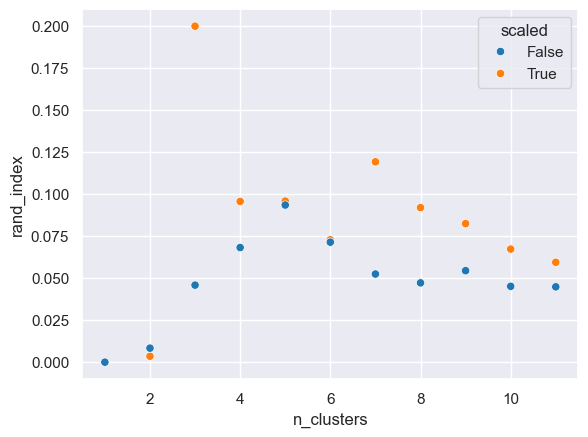

In [219]:
def kmeans_pca(dataset, n_clusters_list):
    
    for scaled in [True,False] :
        
        if scaled == True :
            scaler = StandardScaler()
            kmeans_data = scaler.fit_transform(dataset) 
        else :
            kmeans_data = dataset

        pca_cls = PCA(n_components=21)
        pcs_pca = pca_cls.fit_transform(kmeans_data)

        for n_clusters in n_clusters_list:
            kmeans_cls = KMeans(n_clusters=n_clusters, n_init=200).fit(pcs_pca)
            labels = pd.Series(kmeans_cls.labels_, name="K-means")
            labels = pd.Categorical(labels, categories=[i for i in range(n_clusters)])
            yield n_clusters, scaled, adjusted_rand_score(labels, data['fetal_health'])
            
gen_pca = kmeans_pca(data_without_class, [i+1 for i in range(11)])

df_pca = pd.DataFrame(gen_pca, columns=["n_clusters", "scaled","rand_index"])
df_pca = df_pca.astype({"n_clusters": "int32"})

sns.scatterplot(df_pca, x='n_clusters', y='rand_index', hue='scaled')
plt.show()

Si on utilise un petit nombre d'axes factoriels, on obtient des résultats moins bons qu'en utilisant les données brutes. Si on utilise un grand nombre d'axes factoriels, on obtient des résultats identiques aux résultats avec des données brutes.

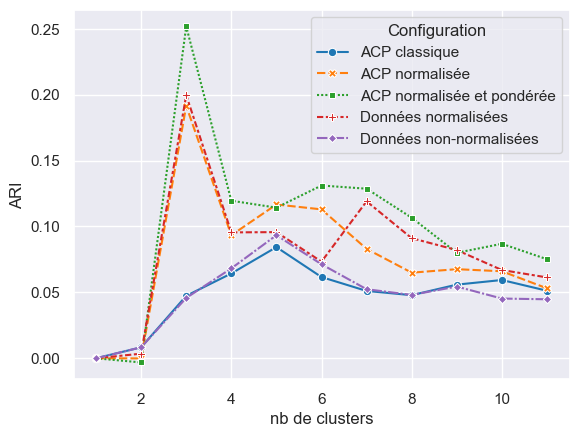

In [243]:
from itertools import chain


def kmeans_pca_2(n_clusters_list):
    
    for dataset in [pcs, pcs_scaled, C] :
        for n_clusters in n_clusters_list:
                cls = KMeans(n_clusters=n_clusters, n_init=200)
                km = cls.fit(dataset[:,0:5])
                labels = pd.Series(cls.labels_, name="K-means")
                labels = pd.Categorical(labels, categories=[i for i in range(n_clusters)])
                if dataset is pcs:
                    yield n_clusters, "ACP classique", adjusted_rand_score(labels, data['fetal_health'])
                elif dataset is pcs_scaled:
                    yield n_clusters, "ACP normalisée", adjusted_rand_score(labels, data['fetal_health'])
                else:
                    yield n_clusters, "ACP normalisée et pondérée", adjusted_rand_score(labels, data['fetal_health'])
                
gen = kmeans_pca_2([i+1 for i in range(11)])
gen2 = kmeans(data_without_class, [i+1 for i in range(11)])

gen3 = chain(gen, gen2)
df = pd.DataFrame(gen3, columns=["nb de clusters", "Configuration", "ARI"])
df = df.astype({"nb de clusters": "int32"})

sns.lineplot(df, x='nb de clusters', y='ARI', hue='Configuration', style='Configuration', markers=True)
plt.savefig("ari_comp.png")
plt.show()